## KoBERT 모델 불러와서 예측하기

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
#KoBERT모델 불러오기
!pip install 'git+https://github.com/SKTBrain/KoBERT.git#egg=kobert_tokenizer&subdirectory=kobert_hf'

In [ ]:
!pip install git+https://git@github.com/SKTBrain/KoBERT.git@master

In [ ]:
!pip install gluonnlp

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import torch
import torch
import pandas as pd
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import gluonnlp as nlp
import numpy as np
from tqdm import tqdm, tqdm_notebook
import tensorflow as tf

In [ ]:
from kobert.utils import get_tokenizer
from kobert.pytorch_kobert import get_pytorch_kobert_model

from transformers import AdamW
from transformers.optimization import get_cosine_schedule_with_warmup
from transformers import BertModel

In [ ]:
class BERTDataset(Dataset):
    def __init__(self, dataset, sent_idx, label_idx, bert_tokenizer,vocab, max_len,
                 pad, pair):
   
        transform = nlp.data.BERTSentenceTransform(
            bert_tokenizer, max_seq_length=max_len,vocab=vocab, pad=pad, pair=pair)
        
        self.sentences = [transform([i[sent_idx]]) for i in dataset]
        self.labels = [np.int32(i[label_idx]) for i in dataset]

    def __getitem__(self, i):
        return (self.sentences[i] + (self.labels[i], ))


    def __len__(self):
        return (len(self.labels))

In [ ]:
class BERTClassifier(nn.Module):
    def __init__(self,
                 bert,
                 hidden_size = 768,
                 num_classes = 2, 
                 dr_rate=None,
                 params=None):
        super(BERTClassifier, self).__init__()
        self.bert = bert
        self.dr_rate = dr_rate
                 
        self.classifier = nn.Linear(hidden_size , num_classes)
        if dr_rate:
            self.dropout = nn.Dropout(p=dr_rate)
    
    def gen_attention_mask(self, token_ids, valid_length):
        attention_mask = torch.zeros_like(token_ids)
        for i, v in enumerate(valid_length):
            attention_mask[i][:v] = 1
        return attention_mask.float()

    def forward(self, token_ids, valid_length, segment_ids):
        attention_mask = self.gen_attention_mask(token_ids, valid_length)
        
        _, pooler = self.bert(input_ids = token_ids, token_type_ids = segment_ids.long(), attention_mask = attention_mask.float().to(token_ids.device))
        if self.dr_rate:
            out = self.dropout(pooler)
        return self.classifier(out)

In [ ]:
#CPU사용시
#device = torch.device("cpu:0")

#GPU 사용 시
device = torch.device("cuda:0")

In [ ]:
#모델 불러오기
path = '/content/gdrive/MyDrive/CUAI/CUAI/하계 프로젝트/'
model = torch.load(path + 'KoBERT_감정분석2.pt')  # 전체 모델을 통째로 불러옴, 클래스 선언 필수
#GPU사용 불가일 경우, map_location=torch.device('cpu') 해줘야 함
model.load_state_dict(torch.load(path + 'model_state_dict2.pt'))  # state_dict를 불러 온 후, 모델에 저장

<All keys matched successfully>

In [ ]:
data = pd.read_excel('/content/gdrive/MyDrive/CUAI/CUAI/하계 프로젝트/final_data.xlsx', engine = 'openpyxl')

In [ ]:
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(data, random_state=42, shuffle = True, stratify = data['label'])

In [ ]:
train_data = train_data[['document', 'label']]
test_data = test_data[['document', 'label']]

In [ ]:
#BERTDataset에 들어가는 데이터의 형식은 기존의 train_data, test_data와 다르다.
  #리스트 안에 리스트가 있는 형식으로 들어가야 하는 것 같다.
    #data = [['나 오늘 기분이 좋아', 1], ['오늘 날씨가 너무 안좋아서 꿀꿀하네', 0]] 이런 식으로
    #따라서 기존의 train_data, test_data를 위의 형식으로 바꿔야 한다.
train_data_list = []
for sent, label in zip(train_data['document'], train_data['label']):
  data = []
  data.append(sent)
  data.append(str(label))
  train_data_list.append(data)

In [ ]:
train_data_list[1]

['다시 보고 싶다 앙코르 해주면 좋겠다', '1']

In [ ]:
test_data_list = []
for sent, label in zip(test_data['document'], test_data['label']):
  data = []
  data.append(sent)
  data.append(str(label))
  test_data_list.append(data)

In [ ]:
test_data_list[1]

['삼식이 짱 드래건도 짱', '1']

In [ ]:
bertmodel, vocab = get_pytorch_kobert_model(cachedir=".cache")

using cached model. /content/.cache/kobert_v1.zip
using cached model. /content/.cache/kobert_news_wiki_ko_cased-1087f8699e.spiece


In [ ]:
tokenizer = get_tokenizer()
tok = nlp.data.BERTSPTokenizer(tokenizer, vocab, lower=False)

using cached model. /content/.cache/kobert_news_wiki_ko_cased-1087f8699e.spiece


In [ ]:
max_len = 25
batch_size = 64
warmup_ratio = 0.1
num_epochs = 15
max_grad_norm = 1
log_interval = 100
learning_rate =  5e-5
data_train = BERTDataset(train_data_list, 0, 1, tok, vocab, max_len, True, False)
data_test = BERTDataset(test_data_list, 0, 1, tok, vocab, max_len, True, False)

In [ ]:
train_dataloader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, num_workers=2)
test_dataloader = torch.utils.data.DataLoader(data_test, batch_size=batch_size, num_workers=2)

In [ ]:
def predict(sent):
    data = [sent, '1']
    data_set = [data]
    test_data = BERTDataset(data_set, 0, 1, tok, vocab, max_len, True, False)
    test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=128, num_workers=2)
  

    model.eval()
    with torch.no_grad():
        for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(test_dataloader):
            token_ids = token_ids.long().to(device)
            segment_ids = segment_ids.long().to(device)

            valid_length= valid_length
            label = label.long().to(device)

            out = model(token_ids, valid_length, segment_ids)
            
            test = []
            prob = []
            for i in out:
                logits = i
                logits = logits.detach().cpu().numpy()
                if np.argmax(logits) == 0:
                    test.append('부정')
                    prob.append(logits[0])
                elif np.argmax(logits) == 1:
                    test.append('긍정')
                    prob.append(logits[1])
            print('{}일 확률: {}'.format(test[0], float(torch.sigmoid(torch.tensor(prob)))))

In [ ]:
out = predict('내용이해  진짜 잘 되게 설명해주시고 친절하십니다과제도 없고 시험만 잘 보면 되니까 깔끔한듯')

긍정일 확률: 0.9796695709228516


## confusion matrix

In [ ]:
def calc_accuracy(X,Y):
    max_vals, max_indices = torch.max(X, 1)
    train_acc = (max_indices == Y).sum().data.cpu().numpy()/max_indices.size()[0]
    return train_acc

In [ ]:
#GPU캐시 삭제해주기
import torch, gc
gc.collect()
torch.cuda.empty_cache()

In [ ]:
with torch.no_grad():
    prob = []
    for batch_id, (token_ids, valid_length, segment_ids, label) in tqdm(enumerate(test_dataloader), total=len(test_dataloader)):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        prob.append(out)

print(prob)

In [ ]:
prob1 = torch.cat(prob, 0) #prob를 torch로 바꾸기
y_pred = torch.sigmoid(prob1) #torch.sigmoid 
y_pred = torch.argmax(y_pred, 1).detach().cpu().numpy() #예측 값 => detach로 grad 빼주고 => 넘파이 배열로 변환
y_pred

array([1, 1, 0, ..., 0, 0, 0])

In [ ]:
test_labels = test_data['label'].values #label을 넘파이 배열로 바꿈

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(test_labels, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.92      0.92     47465
           1       0.86      0.85      0.86     28404

    accuracy                           0.89     75869
   macro avg       0.89      0.89      0.89     75869
weighted avg       0.89      0.89      0.89     75869



              precision    recall  f1-score   support

           0       0.92      0.91      0.92     47848
           1       0.85      0.86      0.86     28021

    accuracy                           0.89     75869
   macro avg       0.89      0.89      0.89     75869
weighted avg       0.90      0.89      0.89     75869



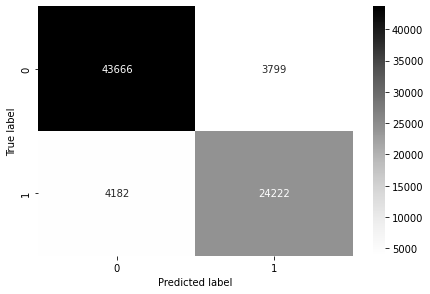

In [ ]:
%matplotlib inline  
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import classification_report

def visualize_confusion_matrix(y_pred_argmax, y_true):
    cm = tf.math.confusion_matrix(y_true, y_pred_argmax).numpy()
    con_mat_df = pd.DataFrame(cm)
    
    print(classification_report(y_pred_argmax, y_true))

    sns.heatmap(con_mat_df, annot=True, fmt='g', cmap=plt.cm.Greys)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

visualize_confusion_matrix(y_pred, test_labels)

# 에브리타임 강의평 

In [ ]:
#데이터 전처리를 좀 해줘야 할 것 같음

import pandas as pd
lecture_review = pd.read_csv(path + 'review_list.txt', sep = '\t', encoding = 'utf-8')

In [ ]:
lecture_review_lst = lecture_review.values.tolist()
lecture_review_lst